In [31]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import zipfile

In [32]:
parent = 'jigsaw-toxic-comment-classification-challenge/'
train_name = 'train.csv'
test_name = 'test.csv'
test_lb_name = 'test_labels.csv'

def read_zip_csv(parent, filename):
    zf = zipfile.ZipFile(parent+filename+'.zip')
    return pd.read_csv(zf.open(filename))

train_df = read_zip_csv(parent, train_name)
test_df = read_zip_csv(parent, test_name)
test_lb_df = read_zip_csv(parent, test_lb_name)

In [33]:
print(train_df.shape)
print(test_df.shape)
print(test_lb_df.shape)

(159571, 8)
(153164, 2)
(153164, 7)


In [34]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [38]:
train_df.isna().any().sum()

0

In [39]:
# binary distribution in each class
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
proportions = []
for label in labels:
    proportion = np.round(sum(train_df[label]==1)/len(train_df), 2)
    proportions.append(proportion)
pd.DataFrame(list(zip(labels, proportions))).rename(columns={0:'label', 1:'proportion of label=1'})

,label,proportion of label=1
0,toxic,0.10
1,severe_toxic,0.01
2,obscene,0.05
3,threat,0.00
4,insult,0.05
5,identity_hate,0.01


<AxesSubplot:title={'center':'Labels Count'}>

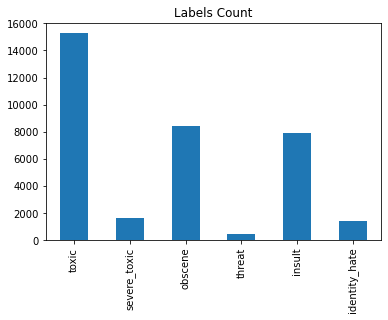

In [40]:
label_count = train_df[labels].sum()
label_count.plot(kind='bar', title='Labels Count')

In [41]:
# null values
train_df.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

<AxesSubplot:title={'center':'Correlation of labels'}>

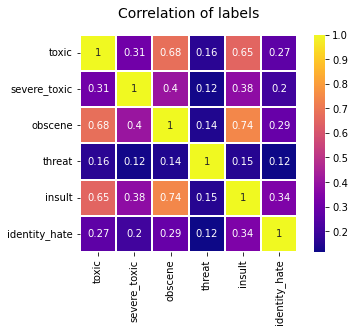

In [42]:
import seaborn as sns

colormap = plt.cm.plasma
plt.title('Correlation of labels',y=1.05,size=14)
sns.heatmap(train_df[labels].astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

In [58]:
import nltk
from nltk.corpus import stopwords

In [59]:
#https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
def preprocess(data):
    '''This function removes punct, stop words and lower cased the words'''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°\
£€\×™√²—–&'
    punct += '©^®` <→°€™› ♥←×§″′Â█½à…“★”–●â►−¢²¬░¶↑±¿▾═¦║―¥▓—‹─▒：¼⊕▼▪†■’▀¨▄♫☆é¯♦¤▲è¸¾Ã⋅‘∞∙）↓、│\
    （»，♪╩╚³・╦╣╔╗▬❤ïØ¹≤‡√'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = clean_special_chars(str(data), punct)
    data = data.split()
    stop_words = set(stopwords.words('english'))
    cleaned = [word.lower() for word in data if word not in stop_words]
    return " ".join(cleaned)

In [60]:
train_df['char_length'] = train_df['comment_text'].apply(len)
train_df['comment_text'] = train_df['comment_text'].apply(preprocess).astype(str)

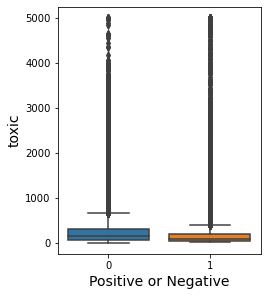

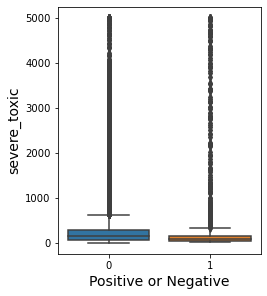

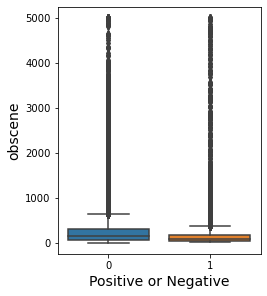

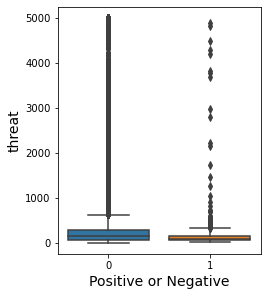

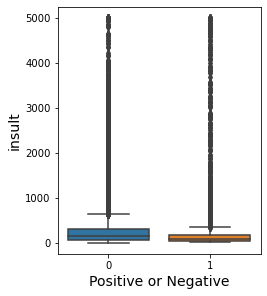

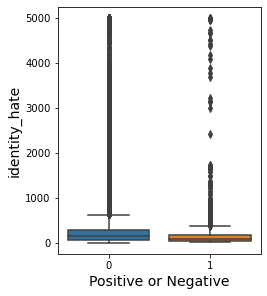

In [57]:
# is char_length related to targets
# Boxplot of Column per Positive / Negative class Value
for l in labels:
    fig = plt.figure(figsize=(8,10))
    sns.boxplot(x=l, y='char_length', data=train_df, ax=plt.subplot(224));
    plt.xlabel('Positive or Negative', fontsize=14);
    plt.ylabel(l, fontsize=14);

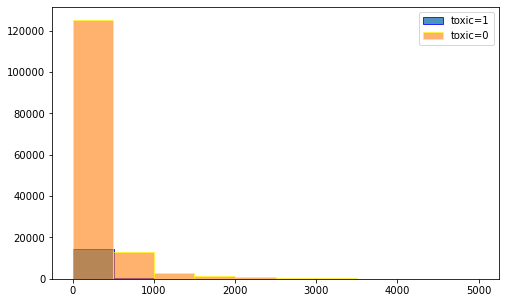

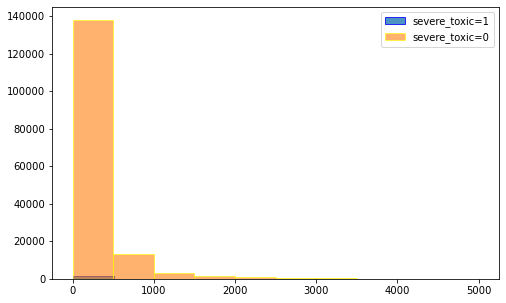

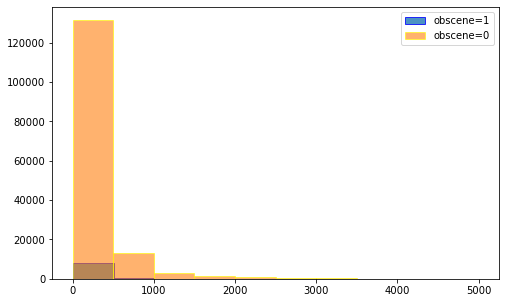

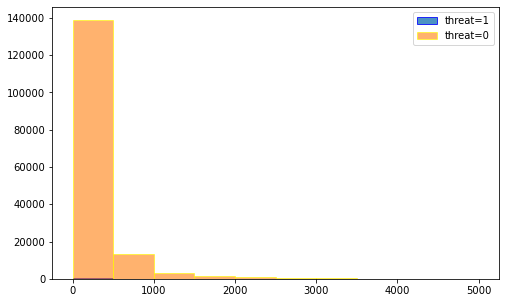

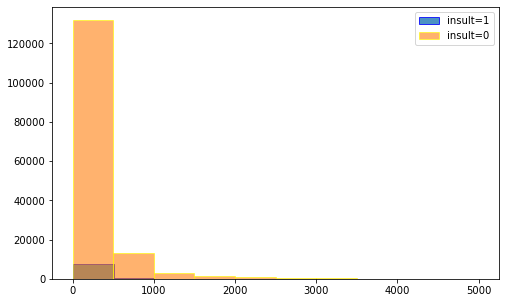

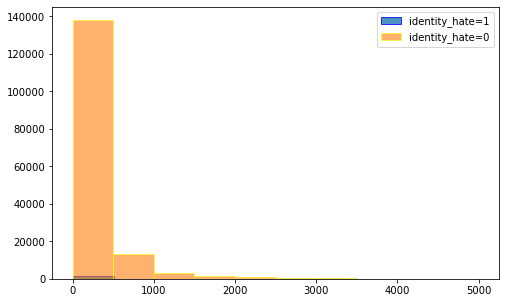

In [65]:
for label in labels:
    fig = plt.figure(figsize=(8,5))
    plt.hist(train_df[train_df[label]==1].char_length, alpha=.8, label=f'{label}=1', edgecolor='blue')
    plt.hist(train_df[train_df[label]==0].char_length, alpha=.6, label=f'{label}=0', edgecolor='yellow')
    plt.legend()
    plt.show()


Text(0.5, 1.0, 'char length of comments')

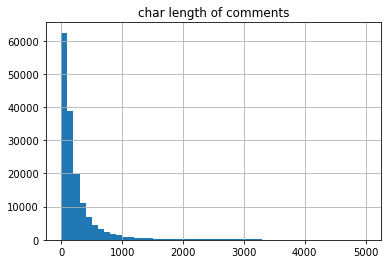

In [23]:
train_df.char_length.hist(bins=50)
plt.title("char length of comments")

In [72]:
train_df.char_length.describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: char_length, dtype: float64

In [61]:
# TFIDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
def Tfidf_Vect(df, word_max_feat=20000, char_max_feat=40000, word_ng_range=(1,3), char_ng_range=(3,6)):
    vect_word = TfidfVectorizer(max_features=word_max_feat, lowercase=True, analyzer='word',
                            stop_words= 'english',ngram_range=word_ng_range,dtype=np.float32)

    vect_char = TfidfVectorizer(max_features=char_max_feat, lowercase=True, analyzer='char',
                            stop_words= 'english',ngram_range=char_ng_range,dtype=np.float32)

    wordvect_train = vect_word.fit_transform(df['comment_text'])
    charvect_train = vect_char.fit_transform(df['comment_text'])
    return sparse.hstack([wordvect_train, charvect_train])

In [64]:
%%time
vect_df = Tfidf_Vect(train_df)

CPU times: user 2min 12s, sys: 20 s, total: 2min 32s
Wall time: 2min 44s


In [66]:
from scipy import sparse
%%time
sparse.save_npz("processed_train.npz", vect_df)
vect_df = sparse.load_npz("processed_train.npz")

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vect_df, 
                                                    train_df[labels], 
                                                    test_size=0.25)

In [82]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, balanced_accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import time

# Reduce Training size

In [98]:
train_df.shape

(159571, 9)

In [99]:
t_index = train_df.index
random_index = np.random.choice(t_index, 50000)

In [100]:
reduced_train = train_df.loc[random_index]

In [106]:
# reduced_train.to_csv("reduced_processed_data.csv")

In [109]:
reduced_train = pd.read_csv("reduced_processed_data.csv").drop(['Unnamed: 0'], axis=1)

In [104]:
reduced_vect_df = Tfidf_Vect(reduced_train)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(reduced_vect_df, 
                                                    reduced_train[labels], 
                                                    test_size=0.25)

# Class weight = 'balanced'

In [69]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [110]:
for i in labels:
    lr = LogisticRegression(
        C=2, 
        random_state=42, 
        class_weight = 'balanced'
    )
    lr.fit(X_train, y_train[i])
    y_pred = lr.predict(X_test)
    print("label:", i)
    print('Confusion matrix:\n', confusion_matrix(y_test[i], y_pred))
    print("Balanced accuracy:", balanced_accuracy_score(y_test[i], y_pred))
    y_pred_pro = lr.predict_proba(X_test)[:,1]
    frp, trp, thres = roc_curve(y_test[i], y_pred_pro)
    auc_val = auc(frp,trp)
    print("AUC score:", auc_val)
    print(classification_report(y_test[i], y_pred))

label: toxic
Confusion matrix:
 [[10882   343]
 [  221  1054]]
Balanced accuracy: 0.8980549368968077
AUC score: 0.9746300886501595
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     11225
           1       0.75      0.83      0.79      1275

    accuracy                           0.95     12500
   macro avg       0.87      0.90      0.88     12500
weighted avg       0.96      0.95      0.96     12500

label: severe_toxic
Confusion matrix:
 [[12215   160]
 [   37    88]]
Balanced accuracy: 0.8455353535353536
AUC score: 0.9829805252525252
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     12375
           1       0.35      0.70      0.47       125

    accuracy                           0.98     12500
   macro avg       0.68      0.85      0.73     12500
weighted avg       0.99      0.98      0.99     12500

label: obscene
Confusion matrix:
 [[11636   146]
 [   91   627]]
Balanced acc

In [111]:
for i in labels:
    lr = LogisticRegression(
        C=2, 
        random_state=42, 
        class_weight = None
    )
    lr.fit(X_train, y_train[i])
    y_pred = lr.predict(X_test)
    print("label:", i)
    print('Confusion matrix:\n', confusion_matrix(y_test[i], y_pred))
    print("Balanced accuracy:", balanced_accuracy_score(y_test[i], y_pred))
    y_pred_pro = lr.predict_proba(X_test)[:,1]
    frp, trp, thres = roc_curve(y_test[i], y_pred_pro)
    auc_val = auc(frp,trp)
    print("AUC score:", auc_val)
    print(classification_report(y_test[i], y_pred))

label: toxic
Confusion matrix:
 [[11156    69]
 [  444   831]]
Balanced accuracy: 0.8228088562819337
AUC score: 0.9742826848333987
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     11225
           1       0.92      0.65      0.76      1275

    accuracy                           0.96     12500
   macro avg       0.94      0.82      0.87     12500
weighted avg       0.96      0.96      0.96     12500

label: severe_toxic
Confusion matrix:
 [[12342    33]
 [   93    32]]
Balanced accuracy: 0.6266666666666667
AUC score: 0.9847938585858586
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12375
           1       0.49      0.26      0.34       125

    accuracy                           0.99     12500
   macro avg       0.74      0.63      0.67     12500
weighted avg       0.99      0.99      0.99     12500

label: obscene
Confusion matrix:
 [[11742    40]
 [  226   492]]
Balanced acc

The 'balanced' parameter does work to increase the balanced accuracy in labels with small proportion/ data, such as threat or identity hate, but the parameter also decreases the precision and recall of other labels. Therefore, we don't consider such approach, or only apply it to labels with increased performance.

From the results above, balanced accuracy works better than AUC score since it accounts for class imbalance. Instead of printing out the results every time, we do a KFold and get the mean balanced accuracy. 

In [126]:
def parameter_tuning(label, name, clf, parameters, crossval=True):
    print("---------  ", name, "  ------------")
    start = time.time()
    if crossval:
        classifier = GridSearchCV(clf, 
                                  parameters, 
                                  cv=5,
                                 scoring="balanced_accuracy",
                                 return_train_score=True)
    else:
        classifier=clf
        
    score_name = 'score'
    
    classifier.fit(X_train, y_train[label])
    means = classifier.cv_results_[f'mean_test_{score_name}']
    r = pd.DataFrame(means, columns = [f'mean_test_{score_name}'])
    r['params'] = classifier.cv_results_['params']
    r['classifier'] = name

    print(f'Training time (CV = {crossval}): \
        {(time.time() - start)/len(means)}')
    
    return r.sort_values(by=[f'mean_test_{score_name}'], ascending=False)

In [123]:
param = {
    'C': [0.5,5,50], 
    'penalty':['l2', 'none'], 
    'class_weight': ['balanced', None]
    }
model = LogisticRegression()

I realize since for each label, no matter what models we use, the scores are in proportion. To tackle the problem of class imbalance, we just need to focus on one label. Here I choose the one that occupies the least proportion among all labels, threat.

In [130]:
threat_lr = parameter_tuning(
                 'threat', 
                 'Logistic Regression', 
                 model, 
                 param, 
                 True)

---------   Logistic Regression   ------------


/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ashleyxiao/opt/ana

Training time (CV = True):         12.185172001520792


In [132]:
threat_lr['params'][0]

{'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2'}

In [149]:
lr_param = threat_lr['params'][0]

In [ ]:
# use it on every label
clf = LogisticRegression()
for label in labels:
    model.fit(X_train, y_train[label])
    y_pred = model.predict(X_test)
    b = balanced_accuracy_score(y_pred, y_test[label])
    a = roc_auc_score(y_test[label], y_pred, average='weighted')
    
    print(f'Balanced accuracy of \'{label}\': {b}')
    print(f'roc_auc_score of \'{label}\': {a}')
    print('\n')

# SVD

In [140]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [142]:
steps = [('svd', TruncatedSVD(n_components=10)), 
         ('lr', LogisticRegression(threat_lr['params'][0]))]
model = Pipeline(steps=steps)

In [148]:
for label in labels:
    model.fit(X_train, y_train[label])
    y_pred = model.predict(X_test)
    b = balanced_accuracy_score(y_pred, y_test[label])
    a = roc_auc_score(y_test[label], y_pred, average='weighted')
    
    print(f'Balanced accuracy of \'{label}\': {b}')
    print(f'roc_auc_score of \'{label}\': {a}')
    print('\n')

Balanced accuracy of 'toxic': 0.8872301617674163
roc_auc_score of 'toxic': 0.6172915847853618


Balanced accuracy of 'severe_toxic': 0.6719382603033192
roc_auc_score of 'severe_toxic': 0.5471111111111112


Balanced accuracy of 'obscene': 0.9476151539929136
roc_auc_score of 'obscene': 0.6747235880803965




/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Balanced accuracy of 'threat': 0.99672
roc_auc_score of 'threat': 0.5


Balanced accuracy of 'insult': 0.9028201286272018
roc_auc_score of 'insult': 0.6280318687714548


Balanced accuracy of 'identity_hate': 0.99064
roc_auc_score of 'identity_hate': 0.5




/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


# Hyperparameter tuning

In [114]:
classifiers = [
    LogisticRegression(),
#     SGDClassifier(loss='log'), # for logistic regression    
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MultinomialNB(),
    GaussianProcessClassifier(),
    GradientBoostingClassifier()
]

In [115]:
names = [
    "Logistic Regression",
#     "Logistic Regression with SGD",
    "Decision Tree Classifier",
    "Random Forest Classifier",
    "Isolation Forest",
    "MultinomialNB",
    "Gaussian Process",
    "Gradient Boosting",    
]

parameters = {
    "Logistic Regression": {
        'C': [0.5,5,50], 
        'penalty':['l2', 'none'], 
        'max_iter': [800],
        'class_weight': ['balanced', None]
    },
#     "Logistic Regression with SGD": {
#         'penalty':['l1','l2', 'none'],
#         'learning_rate' : ['constant','optimal','adaptive'],
#         'eta0' : [0.1]
#     },
    "Decision Tree Classifier": {
        "max_features" : ['sqrt', 'log2', None],
        "max_depth":[5, 15, None],
        "min_samples_split": [2,5,8],
        'class_weight': ['balanced', None]
    },
    "Random Forest Classifier": {
        "n_estimators":[50, 100, 150, 200],
        "max_features" : ['sqrt','log2',None],
        "max_depth":[8,15, None],
        'class_weight': ['balanced', None]
    },
    "Isolation Forest": {
        "n_estimators":[50, 100, 150, 200],
        "max_features" : ['sqrt','log2',None],
        "max_depth":[8,15,30,None]
    },
    "MultinomialNB": {
        "var_smoothing" : [1e-8, 1e-9]
    },
    "Gaussian Process": {
        "n_restarts_optimizer": [1, 2, 3]
    },
    "Gradient Boosting": {
        "max_features" : ['sqrt','log2',None],
        "max_depth":[5, 15, None],
        "learning_rate":[1e-1,1e-3]
    }
}

## Metric evaluation

Toxic comment classification, false positive is equally worse than false negative.

- Precision: the ability of the classifier not to label as positive a sample that is negative

$ \frac{tp}{tp + fp} $

- Recall: the ability of the classifier to find all the positive samples

$\frac{tp}{tp + fn}$

- F1 score: harmonic mean between precision and recall

In [85]:
X_train.shape

(119678, 60000)

In [ ]:
results = pd.DataFrame()
crossval= True
scoring = {"AUC": "roc_auc",
           "Accuracy": make_scorer(balanced_accuracy_score)}
for name, clf in zip(names, classifiers):
    print("---------  ", name, "  ------------")
    start = time.time()
    if crossval:
        classifier = GridSearchCV(clf, 
                                  parameters[name], 
                                  cv=3,
                                 scoring=scoring,
                                 refit="Accuracy",
                                 return_train_score=True)
    else:
        classifier = clf
    
    score_name = 'Accuracy'

    classifier.fit(X_train, y_train['toxic'])
    means = classifier.cv_results_[f'mean_test_{score_name}']
    stds = classifier.cv_results_[f'std_test_{score_name}']
    r = pd.DataFrame(means, columns = [f'mean_test_{score_name}'])
    r[f'std_test_{score_name}'] = stds
    r['params'] = classifier.cv_results_['params']
    r['classifier'] = name

    print(f'Training time (CV = {crossval}): \
        {(time.time() - start)/len(means)}')
    display(r.sort_values(by=[f'mean_test_{score_name}', f'std_test_{score_name}'],
                         ascending=False))
    results = pd.concat([results, r], ignore_index=True)
results_sorted = results.sort_values(by=[f'mean_test_{score_name}', 
                                         f'std_test_{score_name}'],
                                     ascending=False)

---------   Logistic Regression   ------------


/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ashleyxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_mode

Training time (CV = True):         112.42887540658315


,mean_test_Accuracy,std_test_Accuracy,params,classifier
0,0.904800,0.002661,"{'C': 0.5, 'class_weight': 'balanced', 'max_it...",Logistic Regression
4,0.890707,0.002434,"{'C': 5, 'class_weight': 'balanced', 'max_iter...",Logistic Regression
8,0.869902,0.002406,"{'C': 50, 'class_weight': 'balanced', 'max_ite...",Logistic Regression
10,0.844912,0.001201,"{'C': 50, 'class_weight': None, 'max_iter': 80...",Logistic Regression
3,0.843124,0.003460,"{'C': 0.5, 'class_weight': None, 'max_iter': 8...",Logistic Regression
7,0.843124,0.003460,"{'C': 5, 'class_weight': None, 'max_iter': 800...",Logistic Regression
11,0.843124,0.003460,"{'C': 50, 'class_weight': None, 'max_iter': 80...",Logistic Regression
1,0.841675,0.002628,"{'C': 0.5, 'class_weight': 'balanced', 'max_it...",Logistic Regression
5,0.841675,0.002628,"{'C': 5, 'class_weight': 'balanced', 'max_iter...",Logistic Regression
9,0.841675,0.002628,"{'C': 50, 'class_weight': 'balanced', 'max_ite...",Logistic Regression


---------   Decision Tree Classifier   ------------
